## 1. Import Libraries & Load Data

In [36]:
import sys
sys.path.append("../src")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set display options => to display all columns and with full width
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Load cleaned data
file_path = "../data/processed/Cleaned_data.xlsx"

product_lookup = pd.read_excel(file_path, sheet_name=' Product Lookup')
product_subcategory = pd.read_excel(file_path, sheet_name='Product Subcategory')
product_category = pd.read_excel(file_path, sheet_name='Product Category')
sales_data = pd.read_excel(file_path, sheet_name='Sales Data')
returns_data = pd.read_excel(file_path, sheet_name='Returns Data')
calendar_lookup = pd.read_excel(file_path, sheet_name='Calendar Lookup')

## 2. Data Integration
### 2.1 Merge Products with Categories

In [37]:
# Merge Product Lookup with Subcategory
products_with_subcat = product_lookup.merge(
    product_subcategory,
    on='ProductSubcategoryKey',
    how='left'
)

# Merge with Category
products_full = products_with_subcat.merge(
    product_category,
    on='ProductCategoryKey',
    how='left'
)

print(f"Products merged with categories: {products_full.shape}")
print(f"Categories: {products_full['CategoryName'].unique()}")
products_full.head()

Products merged with categories: (293, 15)
Categories: ['Accessories' 'Clothing' 'Components' 'Bikes']


,ProductKey,ProductSubcategoryKey,ProductSKU,ProductName,ModelName,ProductDescription,ProductColor,ProductStyle,ProductCost,ProductPrice,SKU Type,Discount Price,SubcategoryName,ProductCategoryKey,CategoryName
0,214,31,HL-U509-R,"Sport-100 Helmet, Red",Sport-100,"Universal fit, well-vented, lightweight , snap...",Red,U,13.0863,34.9900,HL-U509,31.49100,Helmets,4,Accessories
1,215,31,HL-U509,"Sport-100 Helmet, Black",Sport-100,"Universal fit, well-vented, lightweight , snap...",Black,U,12.0278,33.6442,HL-U509,30.27978,Helmets,4,Accessories
2,218,23,SO-B909-M,"Mountain Bike Socks, M",Mountain Bike Socks,Combination of natural and synthetic fibers st...,White,U,3.3963,9.5000,SO-B909,8.55000,Socks,3,Clothing
3,219,23,SO-B909-L,"Mountain Bike Socks, L",Mountain Bike Socks,Combination of natural and synthetic fibers st...,White,U,3.3963,9.5000,SO-B909,8.55000,Socks,3,Clothing
4,220,31,HL-U509-B,"Sport-100 Helmet, Blue",Sport-100,"Universal fit, well-vented, lightweight , snap...",Blue,U,12.0278,33.6442,HL-U509,30.27978,Helmets,4,Accessories


## 2.2 Merge Sales with Products & Categories

In [38]:
# Merge Sales Data with Products (including categories)
sales_full = sales_data.merge(
    products_full[['ProductKey', 'CategoryName', 'SubcategoryName', 'ProductPrice']],
    on='ProductKey',
    how='left'
)

print(f"Sales merged with product categories: {sales_full.shape}")
sales_full.head()

Sales merged with product categories: (56046, 11)


,OrderDate,StockDate,OrderNumber,ProductKey,CustomerKey,TerritoryKey,OrderLineItem,OrderQuantity,CategoryName,SubcategoryName,ProductPrice
0,2020-01-01,2019-09-21,SO45080,332,14657,1,1,1,Bikes,Road Bikes,699.0982
1,2020-01-01,2019-12-05,SO45079,312,29255,4,1,1,Bikes,Road Bikes,3578.2700
2,2020-01-01,2019-10-29,SO45082,350,11455,9,1,1,Bikes,Mountain Bikes,3374.9900
3,2020-01-01,2019-11-16,SO45081,338,26782,6,1,1,Bikes,Road Bikes,699.0982
4,2020-01-02,2019-12-15,SO45083,312,14947,10,1,1,Bikes,Road Bikes,3578.2700


## 2.3 Merge Returns with Products & Categories

In [39]:
# Merge Returns Data with Products (including categories)
returns_full = returns_data.merge(
    products_full[['ProductKey', 'CategoryName', 'SubcategoryName']],
    on='ProductKey',
    how='left'
)

print(f"Returns merged with product categories: {returns_full.shape}")
returns_full.head()

Returns merged with product categories: (1809, 6)


,ReturnDate,TerritoryKey,ProductKey,ReturnQuantity,CategoryName,SubcategoryName
0,2020-01-18,9,312,1,Bikes,Road Bikes
1,2020-01-18,10,310,1,Bikes,Road Bikes
2,2020-01-21,8,346,1,Bikes,Mountain Bikes
3,2020-01-22,4,311,1,Bikes,Road Bikes
4,2020-02-02,6,312,1,Bikes,Road Bikes


## 3. Compute Demand (Sales)
### 3.1 Category-Level Sales Quantity

In [40]:
# Total quantity sold by category
category_sales = sales_full.groupby('CategoryName').agg({
    'OrderQuantity': 'sum',
    'OrderNumber': 'nunique'  # Number of unique orders
}).reset_index()

category_sales.columns = ['CategoryName', 'TotalQuantitySold', 'UniqueOrders']

print("Category-Level Sales (Demand):")
print(category_sales.sort_values('TotalQuantitySold', ascending=False))

Category-Level Sales (Demand):
  CategoryName  TotalQuantitySold  UniqueOrders
0  Accessories              57809         16983
1        Bikes              13929         13929
2     Clothing              12436          6976


Category Sales Distribution

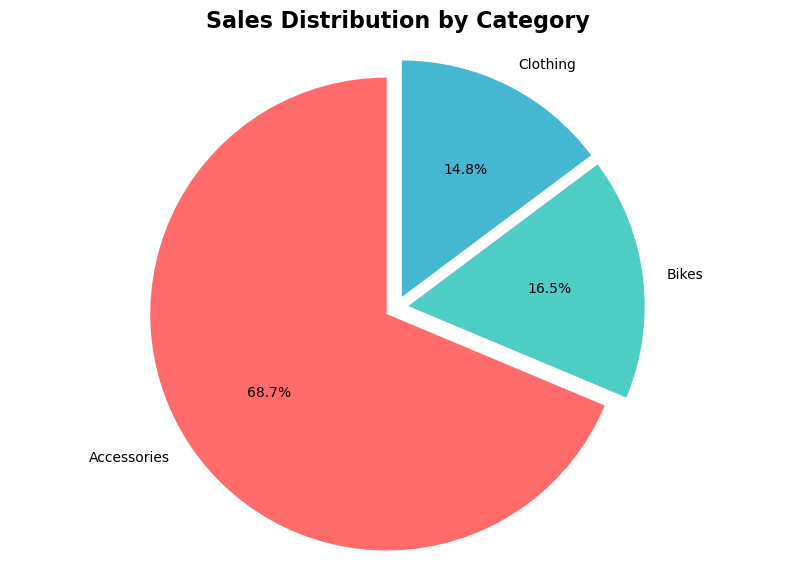

In [41]:
# Pie chart for sales distribution
plt.figure(figsize=(10, 7))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
plt.pie(category_sales['TotalQuantitySold'], 
        labels=category_sales['CategoryName'],
        autopct='%1.1f%%',
        colors=colors,
        startangle=90,
        explode=[0.05] * len(category_sales))
plt.title('Sales Distribution by Category', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.show()

Top 10 Products by Sales

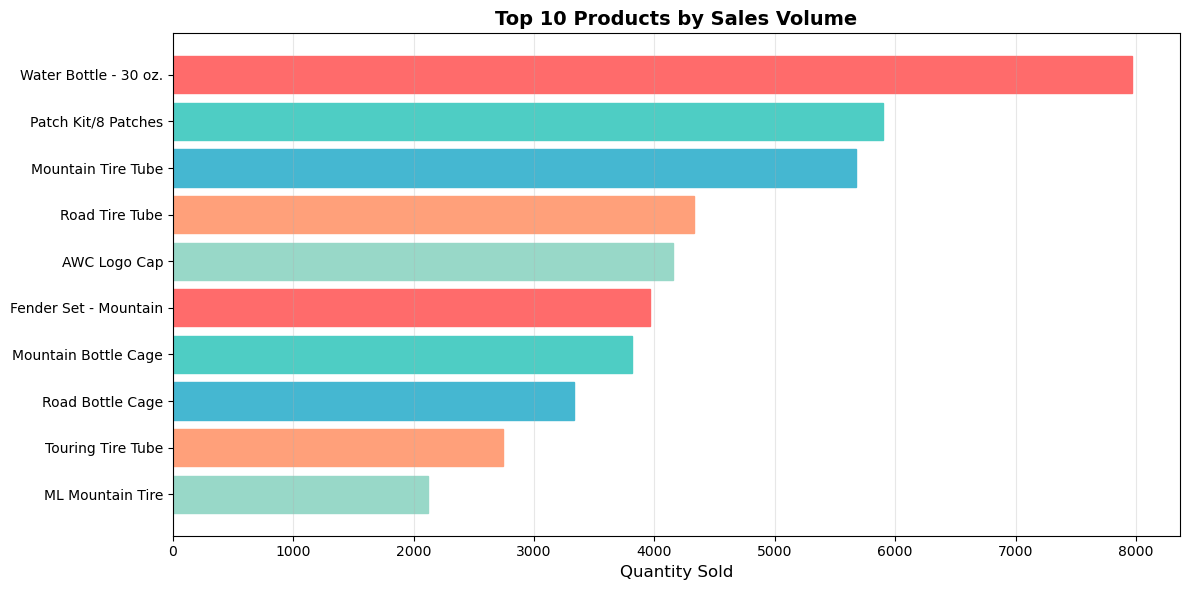

In [42]:
# Top 10 products
top_products = sales_full.groupby(['ProductKey', 'CategoryName']).agg({
    'OrderQuantity': 'sum'
}).reset_index().sort_values('OrderQuantity', ascending=False).head(10)

# Merge to get product names
top_products = top_products.merge(
    products_full[['ProductKey', 'ProductName']], 
    on='ProductKey'
)

plt.figure(figsize=(12, 6))
bars = plt.barh(range(len(top_products)), top_products['OrderQuantity'])
plt.yticks(range(len(top_products)), top_products['ProductName'])
plt.xlabel('Quantity Sold', fontsize=12)
plt.title('Top 10 Products by Sales Volume', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Color bars by category
for i, (bar, cat) in enumerate(zip(bars, top_products['CategoryName'])):
    bar.set_color(colors[i % len(colors)])
    
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 3.2 Monthly Sales Trends by Category

In [43]:
# Add month and year to sales
sales_full['OrderMonth'] = pd.to_datetime(sales_full['OrderDate']).dt.to_period('M')

# Monthly sales by category
monthly_sales = sales_full.groupby(['OrderMonth', 'CategoryName']).agg({
    'OrderQuantity': 'sum'
}).reset_index()

monthly_sales.columns = ['Month', 'CategoryName', 'QuantitySold']

print("Monthly Sales by Category:")
print(monthly_sales.head(10))

Monthly Sales by Category:
     Month CategoryName  QuantitySold
0  2020-01        Bikes           184
1  2020-02        Bikes           165
2  2020-03        Bikes           198
3  2020-04        Bikes           204
4  2020-05        Bikes           206
5  2020-06        Bikes           212
6  2020-07        Bikes           247
7  2020-08        Bikes           278
8  2020-09        Bikes           196
9  2020-10        Bikes           223


## 4. Compute Supply Impact (Returns)
### 4.1 Category-Level Returns

In [44]:
# Total returns by category
category_returns = returns_full.groupby('CategoryName').agg({
    'ReturnQuantity': 'sum'
}).reset_index()

category_returns.columns = ['CategoryName', 'TotalQuantityReturned']

print("Category-Level Returns (Supply Impact):")
print(category_returns.sort_values('TotalQuantityReturned', ascending=False))

Category-Level Returns (Supply Impact):
  CategoryName  TotalQuantityReturned
0  Accessories                   1130
1        Bikes                    429
2     Clothing                    269


## 4.2 Monthly Returns by Category

In [45]:
# Add month and year to returns
returns_full['ReturnMonth'] = pd.to_datetime(returns_full['ReturnDate']).dt.to_period('M')

# Monthly returns by category
monthly_returns = returns_full.groupby(['ReturnMonth', 'CategoryName']).agg({
    'ReturnQuantity': 'sum'
}).reset_index()

monthly_returns.columns = ['Month', 'CategoryName', 'QuantityReturned']

print("Monthly Returns by Category:")
print(monthly_returns.head(10))

Monthly Returns by Category:
     Month CategoryName  QuantityReturned
0  2020-01        Bikes                 4
1  2020-02        Bikes                 4
2  2020-03        Bikes                 9
3  2020-04        Bikes                14
4  2020-05        Bikes                11
5  2020-06        Bikes                 4
6  2020-07        Bikes                 3
7  2020-08        Bikes                 6
8  2020-09        Bikes                 2
9  2020-10        Bikes                11


## 5. Supply & Demand Analysis
### 5.1 Net Demand (Sales - Returns)

In [46]:
# Merge sales and returns at category level
supply_demand = category_sales.merge(
    category_returns,
    on='CategoryName',
    how='left'
)

# Calculate net demand
supply_demand['NetDemand'] = supply_demand['TotalQuantitySold'] - supply_demand['TotalQuantityReturned']

# Calculate return rate
supply_demand['ReturnRate'] = (
    supply_demand['TotalQuantityReturned'] / supply_demand['TotalQuantitySold'] * 100
).round(2)

print("Category-Level Supply & Demand Summary:")
print(supply_demand.sort_values('NetDemand', ascending=False))

Category-Level Supply & Demand Summary:
  CategoryName  TotalQuantitySold  UniqueOrders  TotalQuantityReturned  \
0  Accessories              57809         16983                   1130   
1        Bikes              13929         13929                    429   
2     Clothing              12436          6976                    269   

   NetDemand  ReturnRate  
0      56679        1.95  
1      13500        3.08  
2      12167        2.16  


Correlation Heatmap

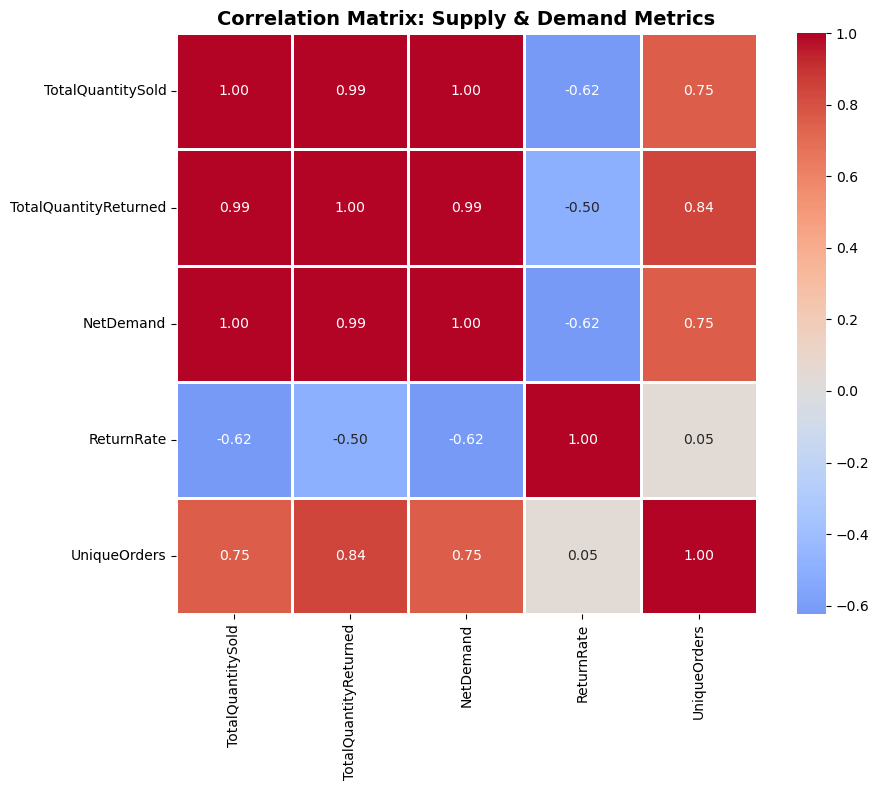

In [47]:
# Correlation between sales, returns, and other metrics
correlation_data = supply_demand[['TotalQuantitySold', 'TotalQuantityReturned', 
                                   'NetDemand', 'ReturnRate', 'UniqueOrders']]

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data.corr(), annot=True, fmt='.2f', 
           cmap='coolwarm', center=0, square=True, linewidths=1)
plt.title('Correlation Matrix: Supply & Demand Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 5.2 Monthly Net Demand Trends

In [48]:
# Convert Month to datetime for merging
monthly_sales['Month'] = monthly_sales['Month'].dt.to_timestamp()
monthly_returns['Month'] = monthly_returns['Month'].dt.to_timestamp()

# Merge monthly sales and returns
monthly_supply_demand = monthly_sales.merge(
    monthly_returns,
    on=['Month', 'CategoryName'],
    how='left'
)

# Calculate monthly net demand
monthly_supply_demand['NetDemand'] = (
    monthly_supply_demand['QuantitySold'] - monthly_supply_demand['QuantityReturned']
)

# Calculate monthly return rate
monthly_supply_demand['ReturnRate'] = (
    monthly_supply_demand['QuantityReturned'] / monthly_supply_demand['QuantitySold'] * 100
).round(2)

print("Monthly Supply & Demand by Category:")
print(monthly_supply_demand.head(15))

Monthly Supply & Demand by Category:
        Month CategoryName  QuantitySold  QuantityReturned  NetDemand  \
0  2020-01-01        Bikes           184                 4        180   
1  2020-02-01        Bikes           165                 4        161   
2  2020-03-01        Bikes           198                 9        189   
3  2020-04-01        Bikes           204                14        190   
4  2020-05-01        Bikes           206                11        195   
5  2020-06-01        Bikes           212                 4        208   
6  2020-07-01        Bikes           247                 3        244   
7  2020-08-01        Bikes           278                 6        272   
8  2020-09-01        Bikes           196                 2        194   
9  2020-10-01        Bikes           223                11        212   
10 2020-11-01        Bikes           191                 5        186   
11 2020-12-01        Bikes           326                13        313   
12 2021-01-01 

## 6. Visualization
### 6.1 Category-Level Demand vs Returns

/tmp/ipykernel_596032/3201726918.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(categories, rotation=45, ha='right')


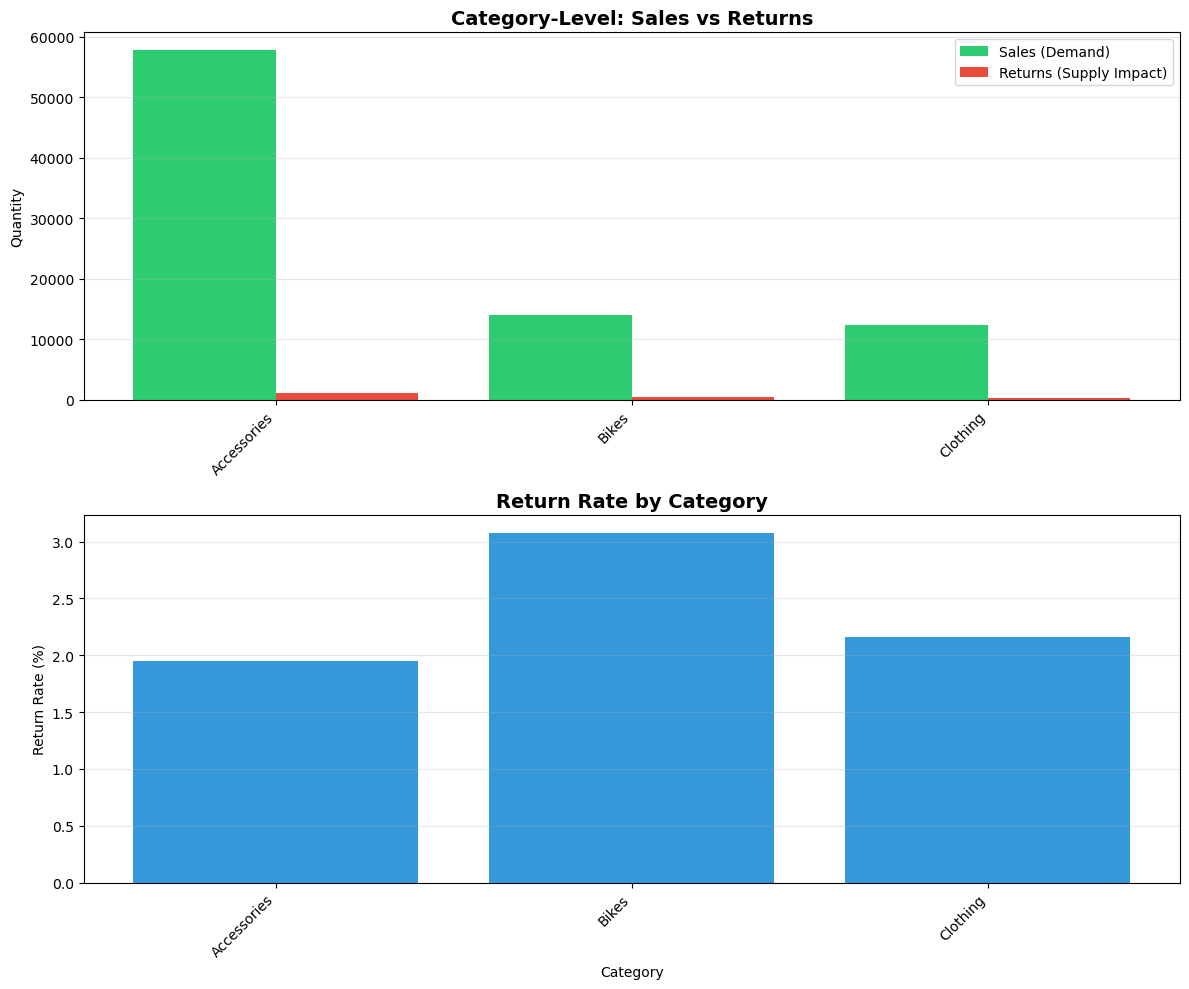

In [49]:
# Create figure
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Total Sales vs Returns by Category
categories = supply_demand['CategoryName']
x_pos = np.arange(len(categories))

axes[0].bar(x_pos - 0.2, supply_demand['TotalQuantitySold'], 
           width=0.4, label='Sales (Demand)', color='#2ecc71')
axes[0].bar(x_pos + 0.2, supply_demand['TotalQuantityReturned'], 
           width=0.4, label='Returns (Supply Impact)', color='#e74c3c')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(categories, rotation=45, ha='right')
axes[0].set_ylabel('Quantity')
axes[0].set_title('Category-Level: Sales vs Returns', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Return Rate by Category
axes[1].bar(categories, supply_demand['ReturnRate'], color='#3498db')
axes[1].set_ylabel('Return Rate (%)')
axes[1].set_xlabel('Category')
axes[1].set_title('Return Rate by Category', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(categories, rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Sales vs Returns Comparison (Stacked Bar)

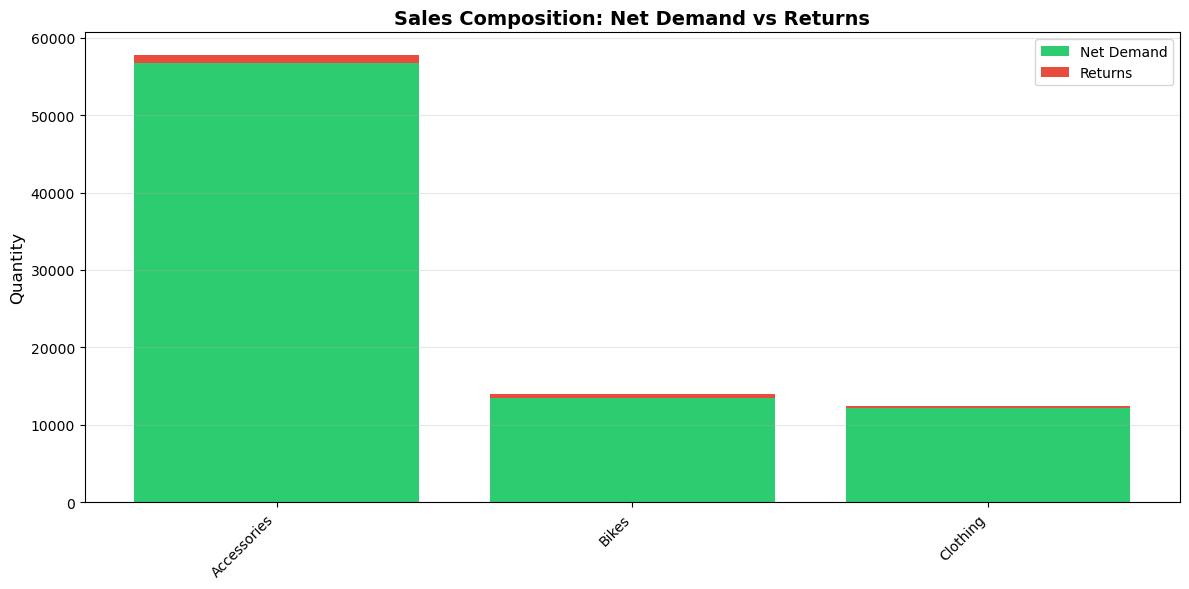

In [50]:
# Stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

categories = supply_demand['CategoryName']
x_pos = np.arange(len(categories))

p1 = ax.bar(x_pos, supply_demand['NetDemand'], color='#2ecc71', label='Net Demand')
p2 = ax.bar(x_pos, supply_demand['TotalQuantityReturned'], 
           bottom=supply_demand['NetDemand'], color='#e74c3c', label='Returns')

ax.set_xticks(x_pos)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.set_ylabel('Quantity', fontsize=12)
ax.set_title('Sales Composition: Net Demand vs Returns', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

 Return Rate Gauge

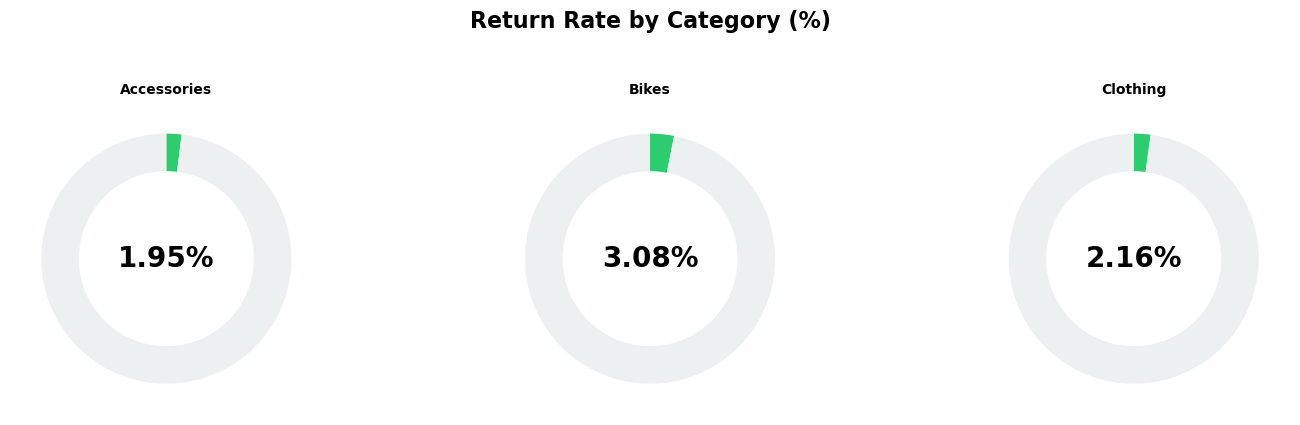

In [51]:
# Create subplots for each category return rate
fig, axes = plt.subplots(1, len(supply_demand), figsize=(15, 4))

for idx, (ax, row) in enumerate(zip(axes, supply_demand.itertuples())):
    # Create gauge
    category = row.CategoryName
    rate = row.ReturnRate
    
    # Determine color based on rate
    if rate < 5:
        color = '#2ecc71'
    elif rate < 10:
        color = '#f39c12'
    else:
        color = '#e74c3c'
    
    # Create pie chart as gauge
    ax.pie([rate, 100-rate], colors=[color, '#ecf0f1'], 
           startangle=90, counterclock=False)
    
    # Add center circle
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    ax.add_artist(centre_circle)
    
    # Add text
    ax.text(0, 0, f'{rate}%', ha='center', va='center', 
           fontsize=20, fontweight='bold')
    ax.set_title(category, fontsize=10, fontweight='bold')

plt.suptitle('Return Rate by Category (%)', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

Category Performance Dashboard

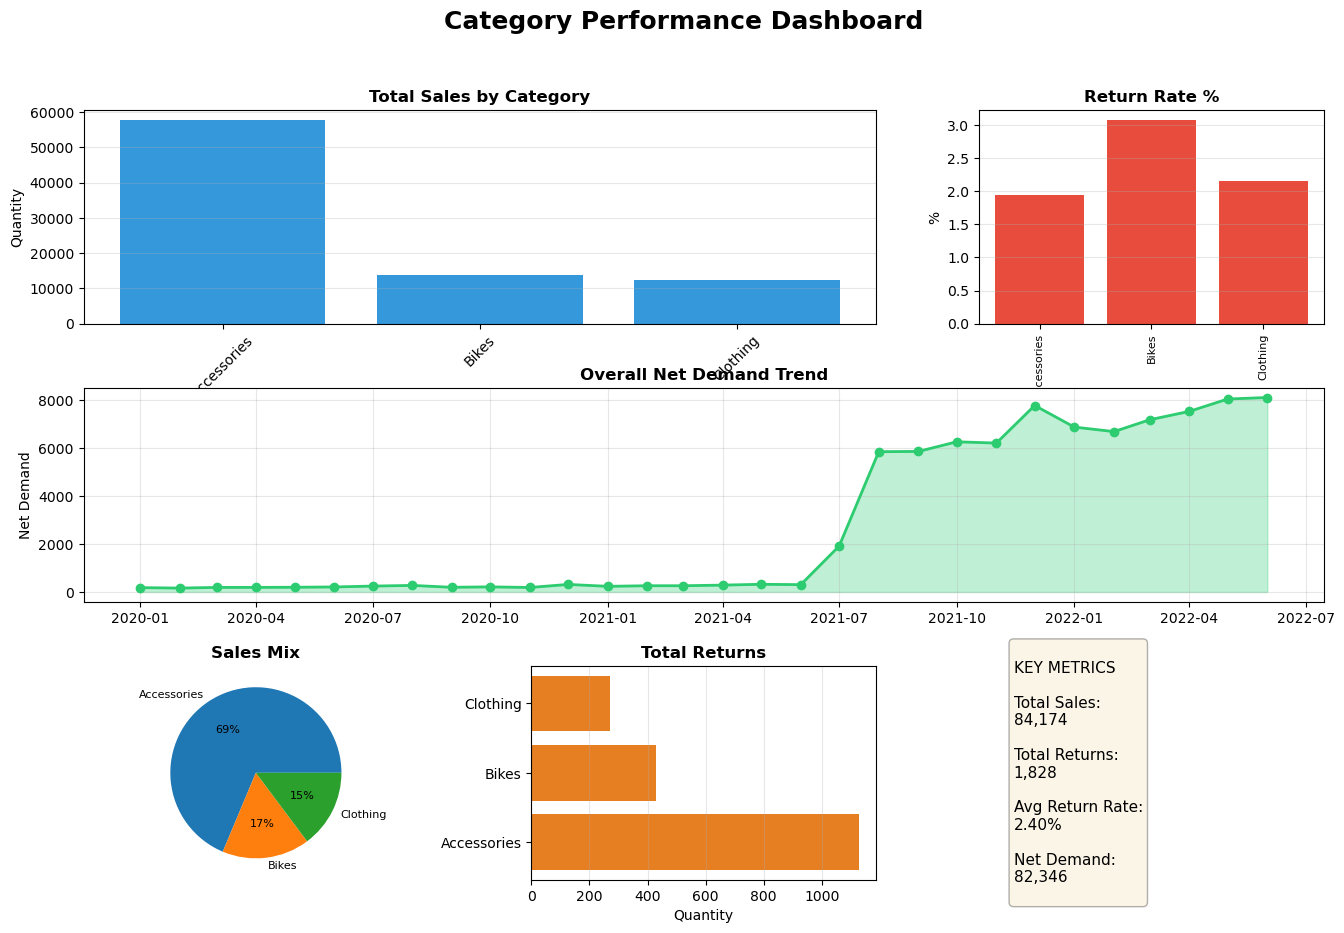

In [52]:
# Create dashboard with multiple metrics
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Sales by Category (top left)
ax1 = fig.add_subplot(gs[0, :2])
ax1.bar(supply_demand['CategoryName'], supply_demand['TotalQuantitySold'], color='#3498db')
ax1.set_title('Total Sales by Category', fontweight='bold')
ax1.set_ylabel('Quantity')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# 2. Return Rate (top right)
ax2 = fig.add_subplot(gs[0, 2])
ax2.bar(supply_demand['CategoryName'], supply_demand['ReturnRate'], color='#e74c3c')
ax2.set_title('Return Rate %', fontweight='bold')
ax2.set_ylabel('%')
ax2.tick_params(axis='x', rotation=90, labelsize=8)
ax2.grid(axis='y', alpha=0.3)

# 3. Net Demand (middle)
ax3 = fig.add_subplot(gs[1, :])
ax3.plot(monthly_supply_demand.groupby('Month')['NetDemand'].sum(), 
        marker='o', linewidth=2, color='#2ecc71')
ax3.fill_between(monthly_supply_demand['Month'].unique(), 
                 monthly_supply_demand.groupby('Month')['NetDemand'].sum(), 
                 alpha=0.3, color='#2ecc71')
ax3.set_title('Overall Net Demand Trend', fontweight='bold')
ax3.set_ylabel('Net Demand')
ax3.grid(True, alpha=0.3)

# 4. Category Mix (bottom left)
ax4 = fig.add_subplot(gs[2, 0])
ax4.pie(category_sales['TotalQuantitySold'], labels=category_sales['CategoryName'],
       autopct='%1.0f%%', textprops={'fontsize': 8})
ax4.set_title('Sales Mix', fontweight='bold')

# 5. Returns by Category (bottom middle)
ax5 = fig.add_subplot(gs[2, 1])
ax5.barh(category_returns['CategoryName'], category_returns['TotalQuantityReturned'], 
        color='#e67e22')
ax5.set_title('Total Returns', fontweight='bold')
ax5.set_xlabel('Quantity')
ax5.grid(axis='x', alpha=0.3)

# 6. Key Metrics (bottom right)
ax6 = fig.add_subplot(gs[2, 2])
ax6.axis('off')
metrics_text = f"""
KEY METRICS

Total Sales:
{supply_demand['TotalQuantitySold'].sum():,}

Total Returns:
{supply_demand['TotalQuantityReturned'].sum():,}

Avg Return Rate:
{supply_demand['ReturnRate'].mean():.2f}%

Net Demand:
{supply_demand['NetDemand'].sum():,}
"""
ax6.text(0.1, 0.5, metrics_text, fontsize=11, verticalalignment='center',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Category Performance Dashboard', fontsize=18, fontweight='bold', y=0.98)
plt.show()

### 6.2 Monthly Trends by Category

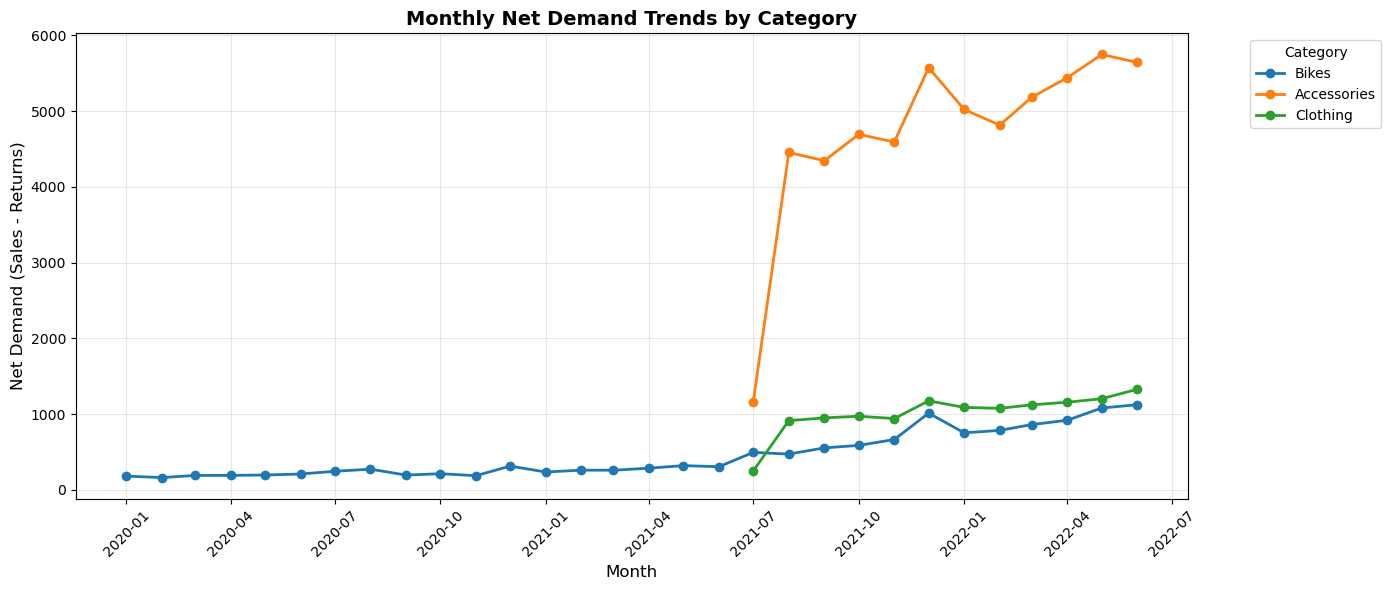

In [53]:
# Create line plot for monthly trends
fig, ax = plt.subplots(figsize=(14, 6))

for category in monthly_supply_demand['CategoryName'].unique():
    category_data = monthly_supply_demand[monthly_supply_demand['CategoryName'] == category]
    ax.plot(category_data['Month'], category_data['NetDemand'], 
           marker='o', label=category, linewidth=2)

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Net Demand (Sales - Returns)', fontsize=12)
ax.set_title('Monthly Net Demand Trends by Category', fontsize=14, fontweight='bold')
ax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 6.3 Heatmap: Monthly Return Rate by Category

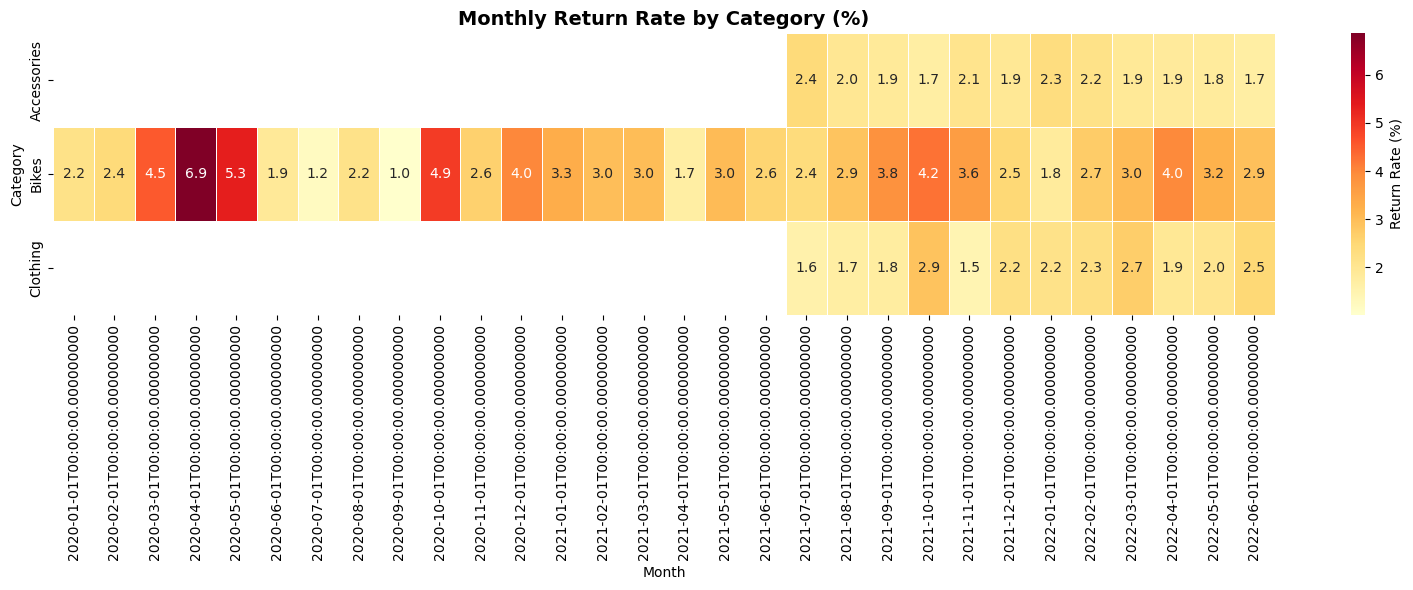

In [54]:
# Pivot data for heatmap
heatmap_data = monthly_supply_demand.pivot(
    index='CategoryName', 
    columns='Month', 
    values='ReturnRate'
)

# Create heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd', 
           cbar_kws={'label': 'Return Rate (%)'}, linewidths=0.5)
plt.title('Monthly Return Rate by Category (%)', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

## 7. Key Insights & Summary

In [55]:
print("=" * 80)
print("KEY INSIGHTS - CATEGORY-LEVEL SUPPLY & DEMAND")
print("=" * 80)

# Highest demand category
top_demand = supply_demand.loc[supply_demand['NetDemand'].idxmax()]
print(f"\nHighest Net Demand: {top_demand['CategoryName']}")
print(f"   - Total Sold: {top_demand['TotalQuantitySold']:,}")
print(f"   - Returns: {top_demand['TotalQuantityReturned']:,}")
print(f"   - Net Demand: {top_demand['NetDemand']:,}")

# Highest return rate
top_return = supply_demand.loc[supply_demand['ReturnRate'].idxmax()]
print(f"\nHighest Return Rate: {top_return['CategoryName']} ({top_return['ReturnRate']}%)")

# Lowest return rate
low_return = supply_demand.loc[supply_demand['ReturnRate'].idxmin()]
print(f"\nLowest Return Rate: {low_return['CategoryName']} ({low_return['ReturnRate']}%)")

print("\n" + "=" * 80)

KEY INSIGHTS - CATEGORY-LEVEL SUPPLY & DEMAND

Highest Net Demand: Accessories
   - Total Sold: 57,809
   - Returns: 1,130
   - Net Demand: 56,679

Highest Return Rate: Bikes (3.08%)

Lowest Return Rate: Accessories (1.95%)



### 8. Export Results

In [56]:
# Save supply & demand summary to Excel
output_path = "../results/Summary/Category_Supply_Demand_Analysis.xlsx"

with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    supply_demand.to_excel(writer, sheet_name='Category Summary', index=False)
    monthly_supply_demand.to_excel(writer, sheet_name='Monthly Trends', index=False)

print(f"Analysis saved to: {output_path}")

Analysis saved to: ../results/Summary/Category_Supply_Demand_Analysis.xlsx
